<a href="https://colab.research.google.com/github/theresatvan/cs-gy-6613-assignments/blob/main/ttv2006_final_takehome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

## Loading the data

Dataset is available [here](https://fred.stlouisfed.org/series/RSXFSN). I downloaded the dataset and uploaded it to my Google Drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Store data in a DataFrame
filepath = '/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/content/RSXFSN.csv'
df = pd.read_csv(filepath)

In [14]:
# Keep real GDP only
keep_columns = ['RSXFSN']
df = df[keep_columns]

# Rescale
df = df/10000

In [15]:
# Sample of what the dataframe looks like
df.head() 

,RSXFSN
0,13.0683
1,13.1244
2,14.2488
3,14.7175
4,15.2420


## Data Preprocessing

In [16]:
# Split train & test data
n_train = int(len(df) * 0.8)
n_test = len(df) - n_train
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]

print("{}, {}".format(len(train), len(test)))

300, 75


In [17]:
def get_timeseries(x, n_steps=1):
  """
  Accepts sample inputs and returns time series data
  """
  x_ts, y_ts = [], []

  for ii in range(len(x) - n_steps):
      v = x.iloc[ii:(ii + n_steps)].values
      x_ts.append(v)
      w = x.iloc[ii + n_steps].values
      y_ts.append(w)

  return np.array(x_ts), np.array(y_ts)

In [18]:
n_steps = 16
n_features = 1

# Convert to a time series dimension: [samples, n_steps, n_features]
x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)

(284, 16, 1) (284, 1)


## Multilayer Perceptron
In this section, we will be creating a multilayer perceptron (MLP) model to predict retail sales. A multilayer perceptron is is a fully connected  feedforward neural network.

### Modeling
Create a MLP.

In [19]:
# Define model
model_mlp = Sequential()
# Add fully-connected layer with 50 nodes
model_mlp.add(Dense(50, activation='relu', input_dim=n_steps))
# Add fully-connected layer with 1 node
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=Adam(0.001))

model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                850       
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


### Training

In [20]:
# Fit the model
history = model_mlp.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/500
8/8 [==============================] - 1s 27ms/step - loss: 167.1124 - val_loss: 56.7981
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 17.3140 - val_loss: 60.9245
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 29.1020 - val_loss: 30.4328
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 7.0604 - val_loss: 13.1732
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 9.6053 - val_loss: 15.6594
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 6.2286 - val_loss: 9.8658
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 6.2076 - val_loss: 11.0635
Epoch 8/500
8/8 [==============================] - 0s 7ms/step - loss: 5.6152 - val_loss: 9.6441
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 5.5429 - val_loss: 9.8054
Epoch 10/500
8/8 [==============================] - 0s 7ms/step - loss: 5.4358 - val_loss: 9.5225
Epoch 11/500
8/8 [

### Evaluation

In [21]:
# Obtain predictions on the test set
y_pred = model_mlp.predict(x_test)

2/2 [==============================] - 0s 4ms/step


In [22]:
# Calculate mean-squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 7.994340955883123


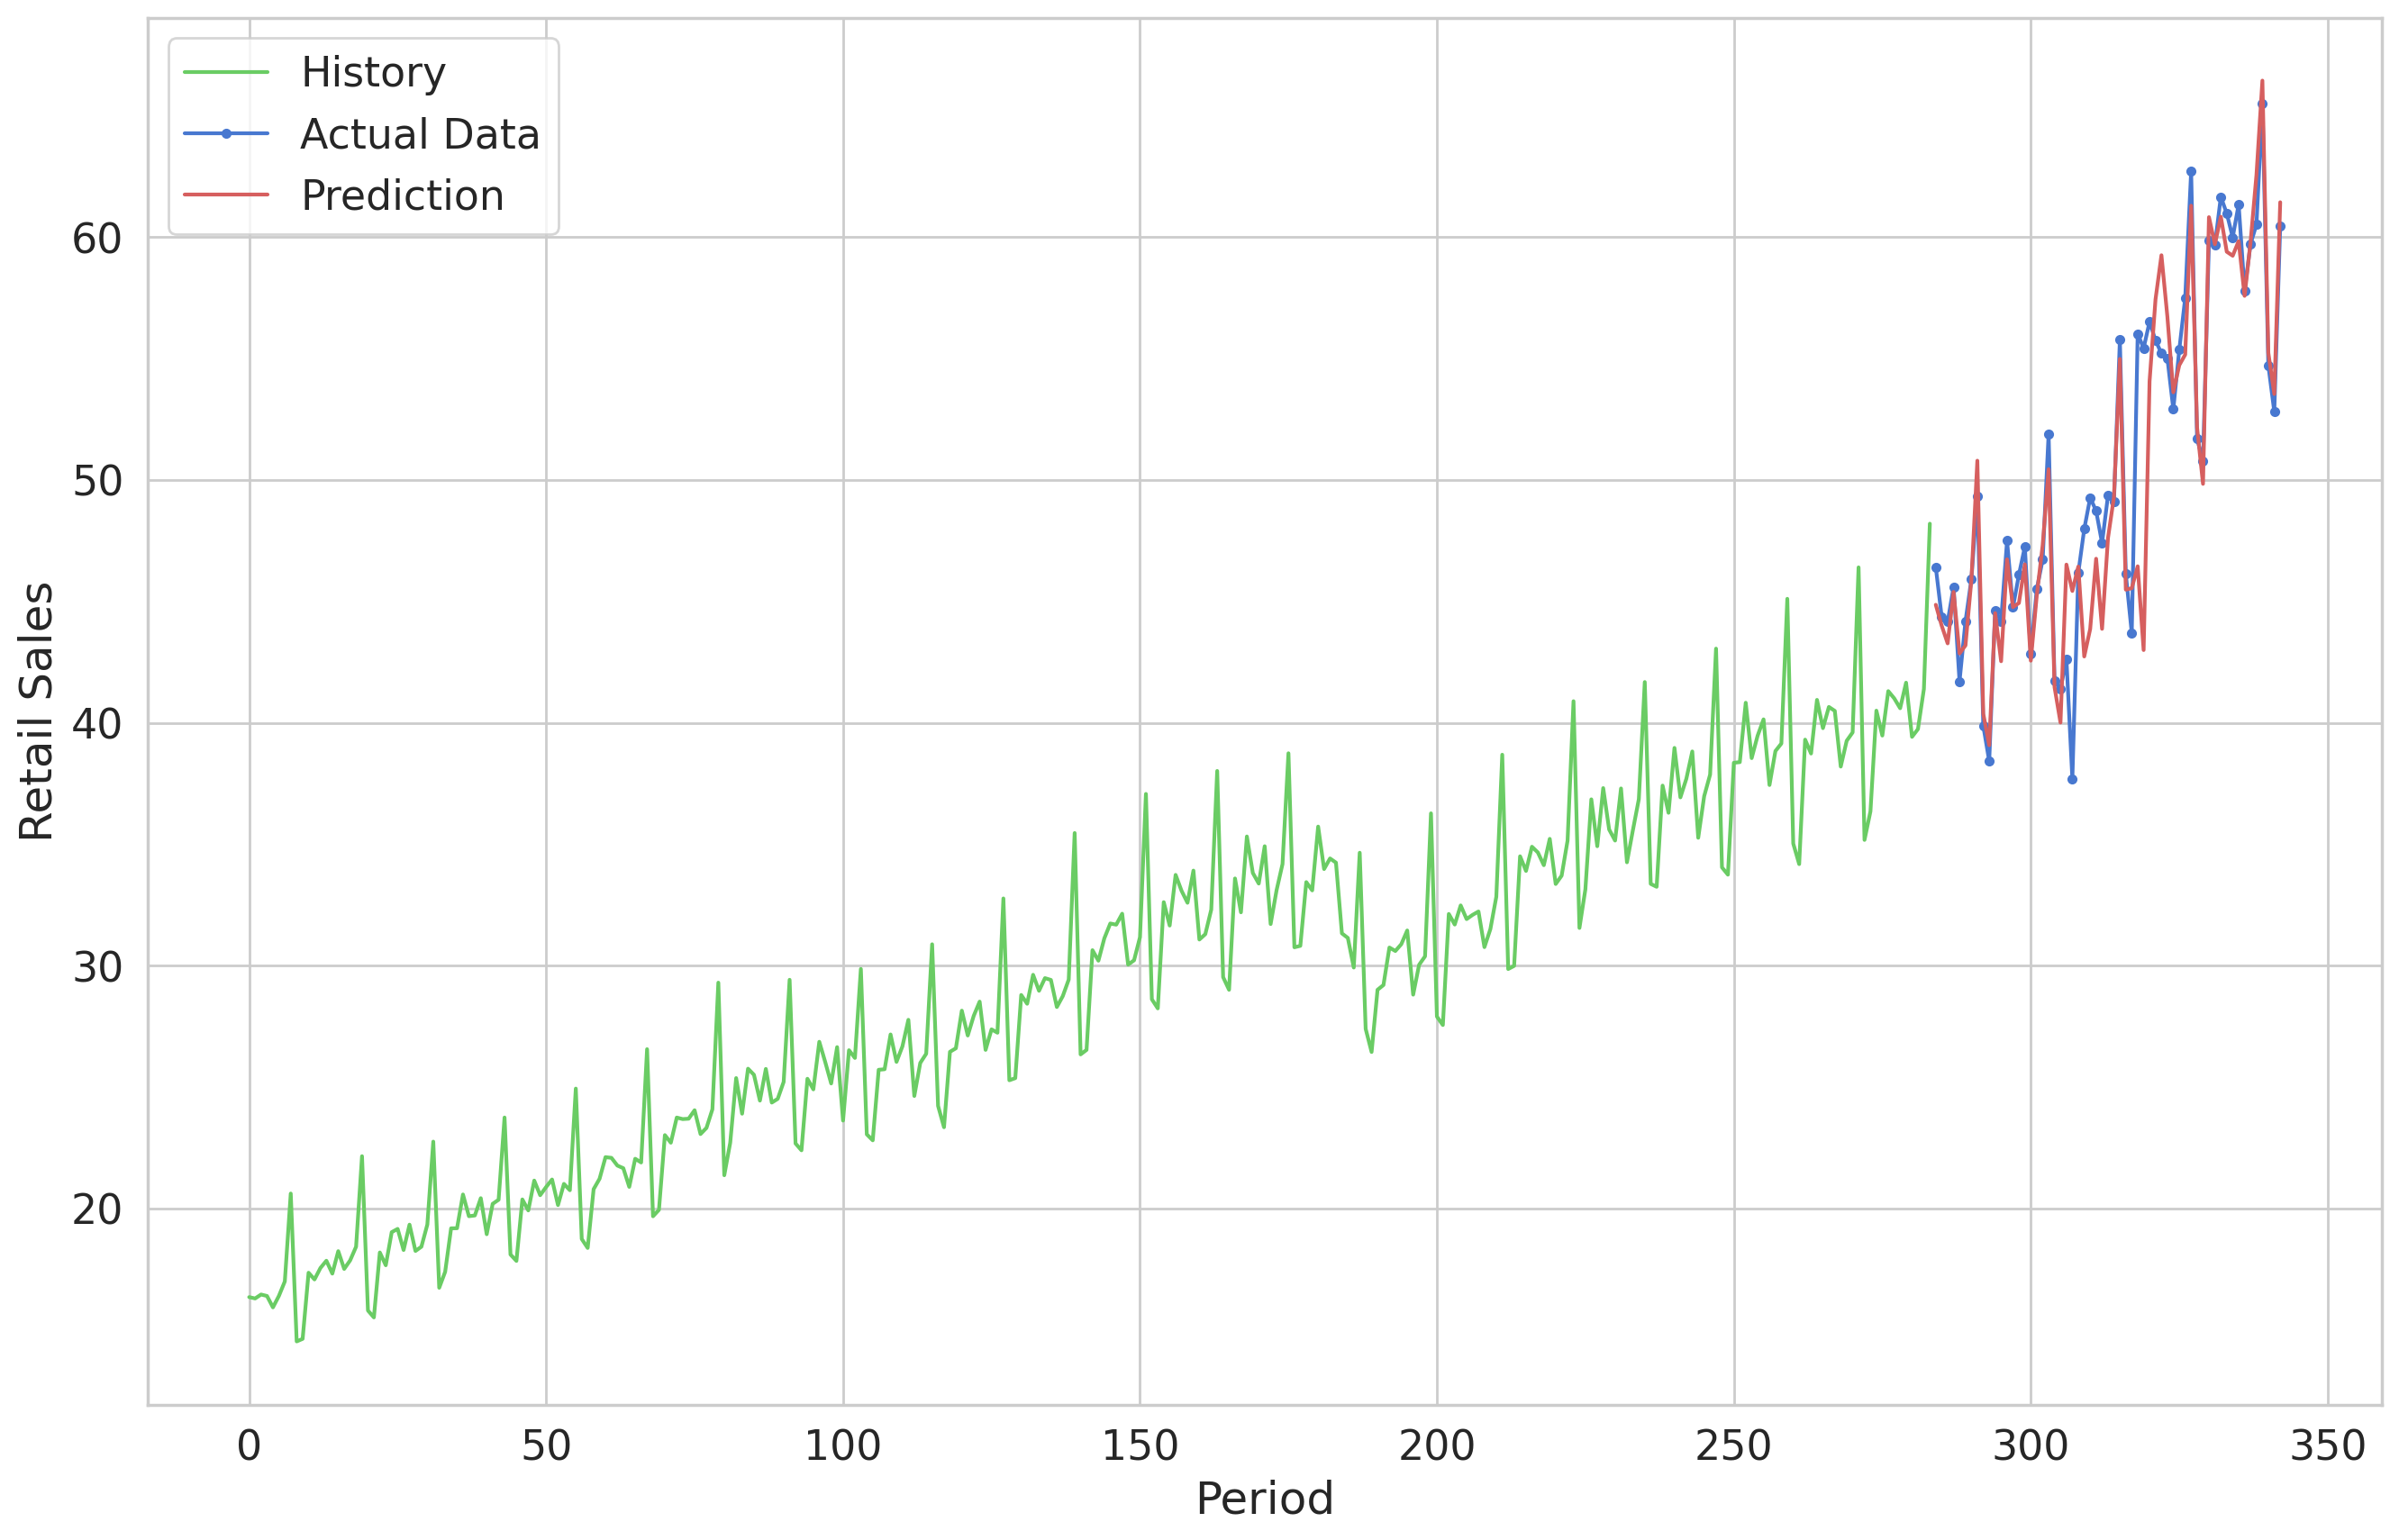

In [23]:
# Visualize predictionss, actual test data, and the training data
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

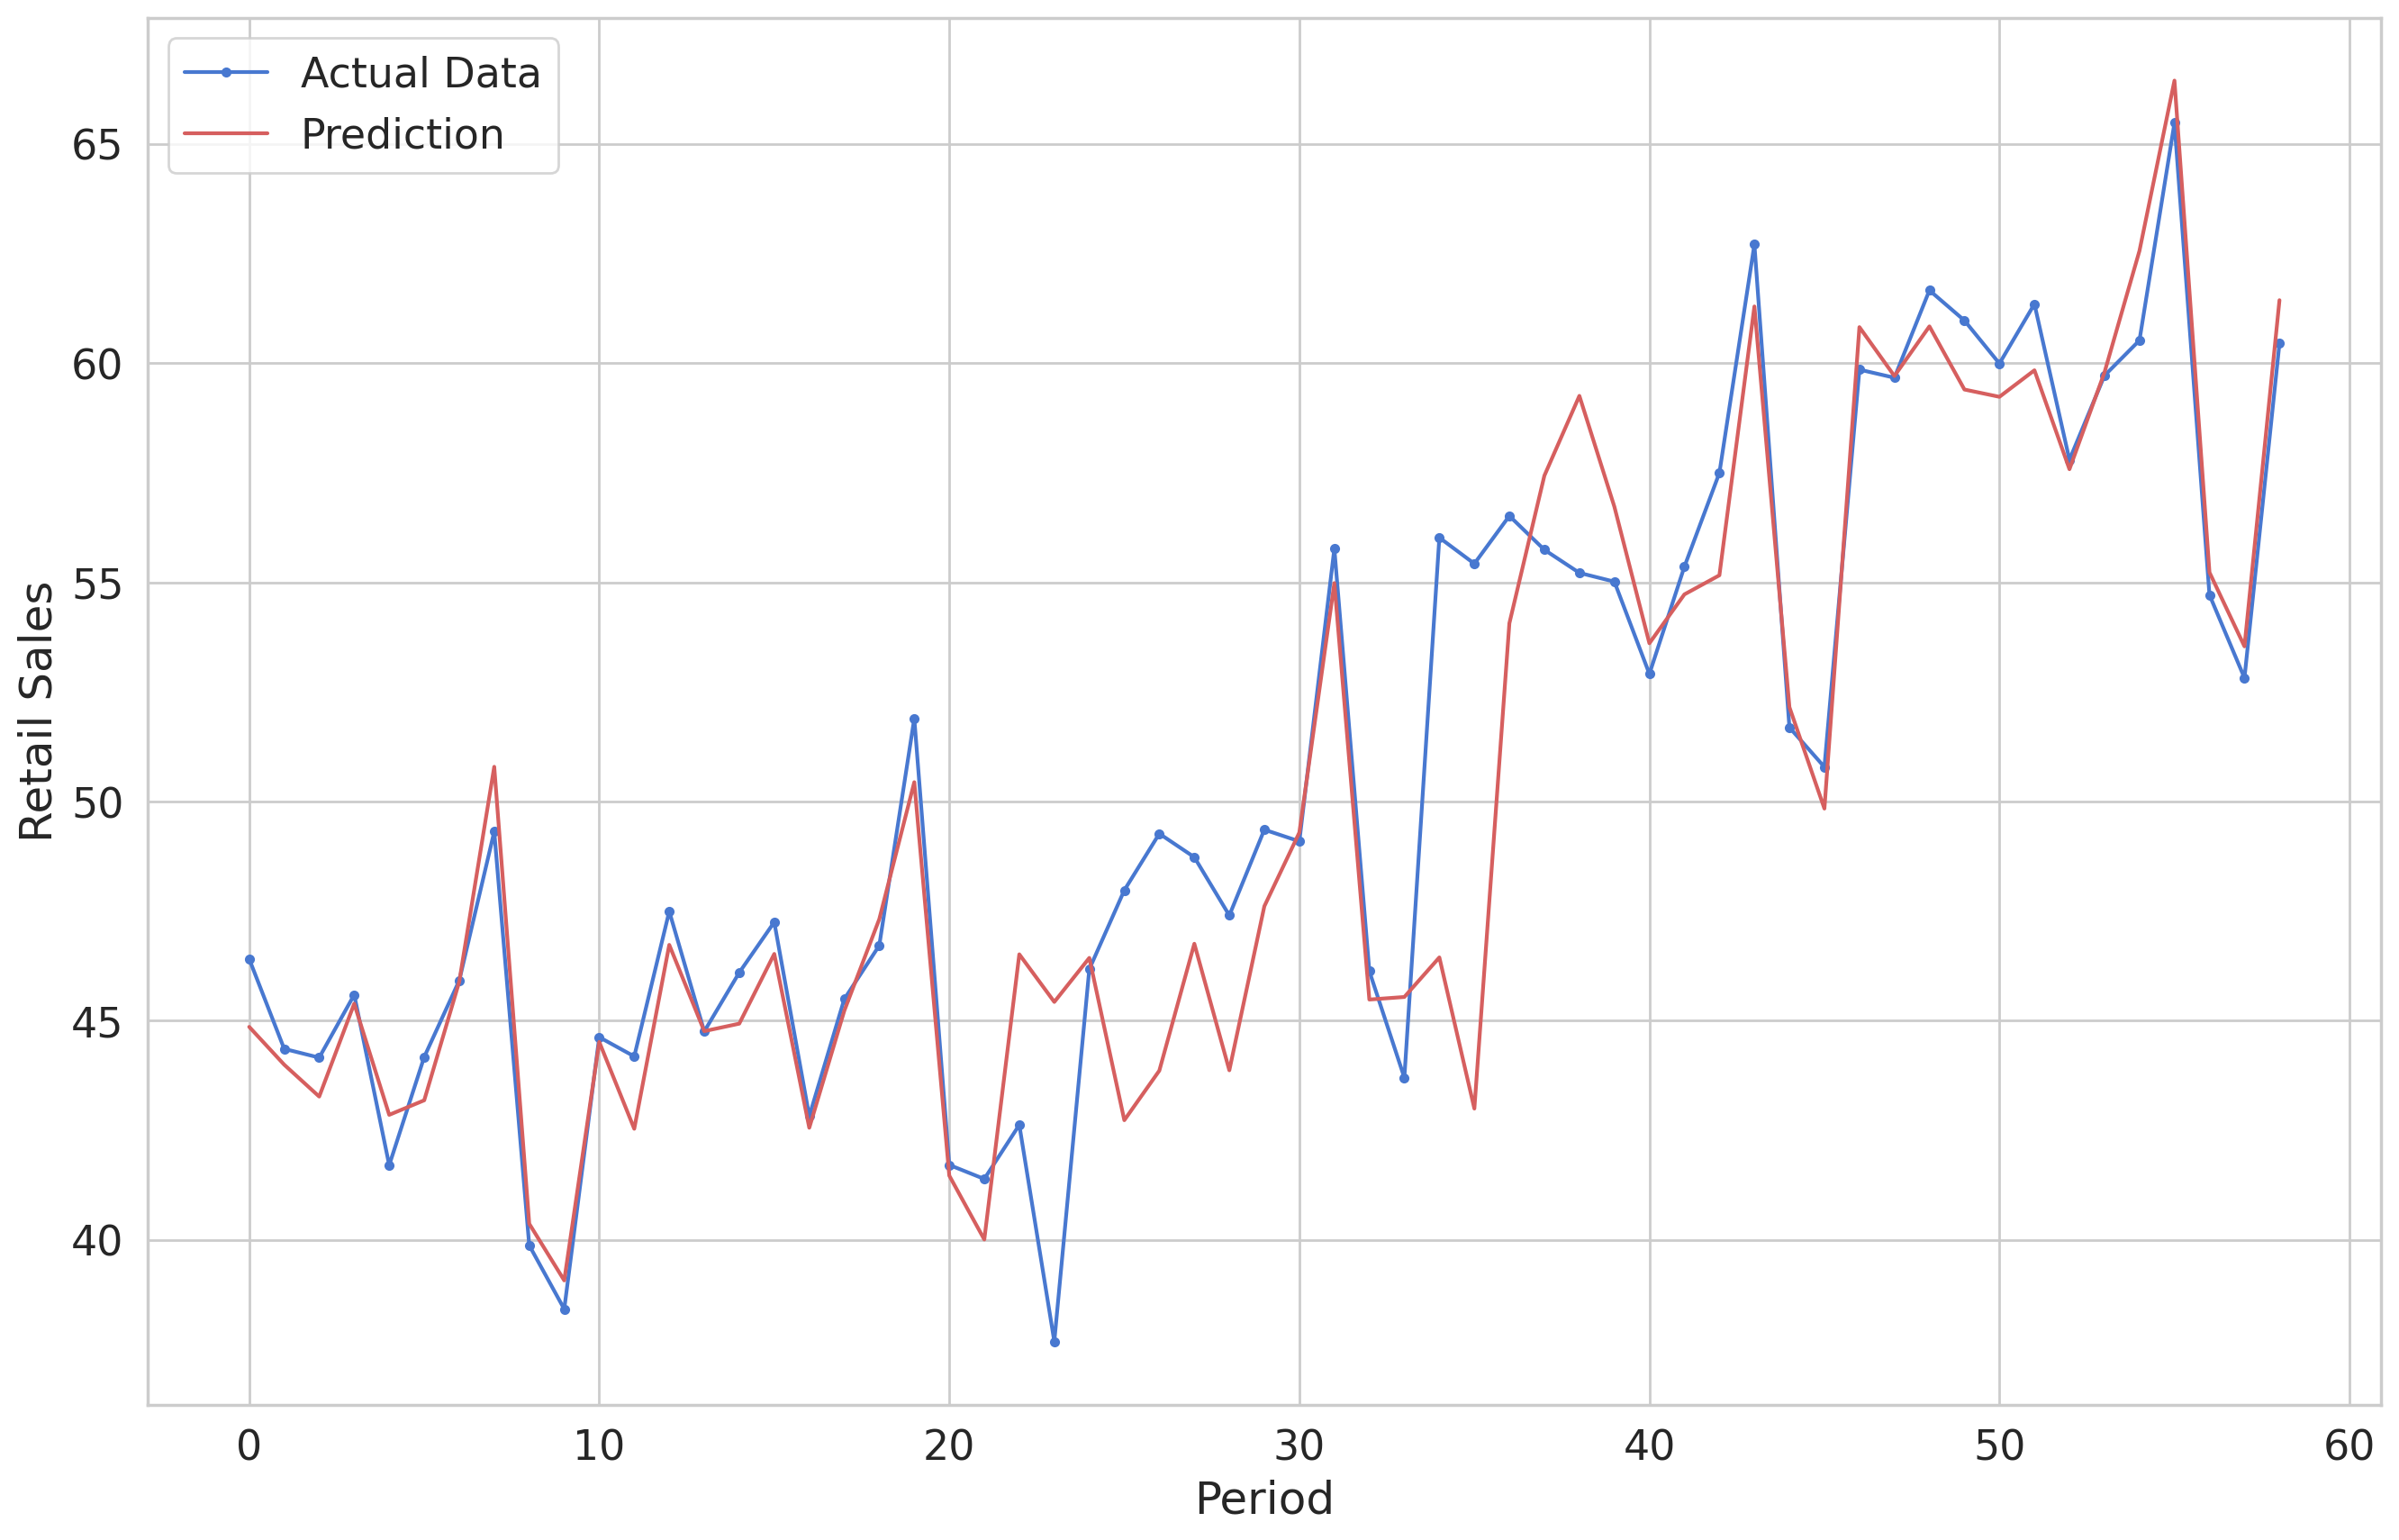

In [24]:
# Visualize predictions and the actual test data
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

## 1D Convolutional Neural Network
Instead of a MLP, we will be using a 1-dimensional convolutional neural network to predict retail sales.

### Modeling

In [25]:
# Define 1D CNN model
model_cnn = Sequential()
# Add convolutional layer
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
# Fully connected layer
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer=Adam(0.001), loss='mse')

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                22450     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 22,757
Trainable params: 22,757
Non-trainable params: 0
__________________________________________________

### Training

In [26]:
# Fit the model
history = model_cnn.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/500
8/8 [==============================] - 3s 30ms/step - loss: 66.6192 - val_loss: 58.7389
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 9.6369 - val_loss: 18.9441
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 8.7956 - val_loss: 8.9626
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 8.2728 - val_loss: 8.7512
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 6.7031 - val_loss: 9.2893
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 6.2053 - val_loss: 8.5438
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 5.1946 - val_loss: 8.4646
Epoch 8/500
8/8 [==============================] - 0s 8ms/step - loss: 5.1923 - val_loss: 7.9891
Epoch 9/500
8/8 [==============================] - 0s 8ms/step - loss: 4.7216 - val_loss: 7.8281
Epoch 10/500
8/8 [==============================] - 0s 7ms/step - loss: 4.7917 - val_loss: 7.6974
Epoch 11/500
8/8 [======

### Evaluation

In [27]:
# Obtain predictions on the test set
y_pred = model_cnn.predict(x_test)

2/2 [==============================] - 0s 14ms/step


In [28]:
# Calculate mean-squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 5.879933400591434


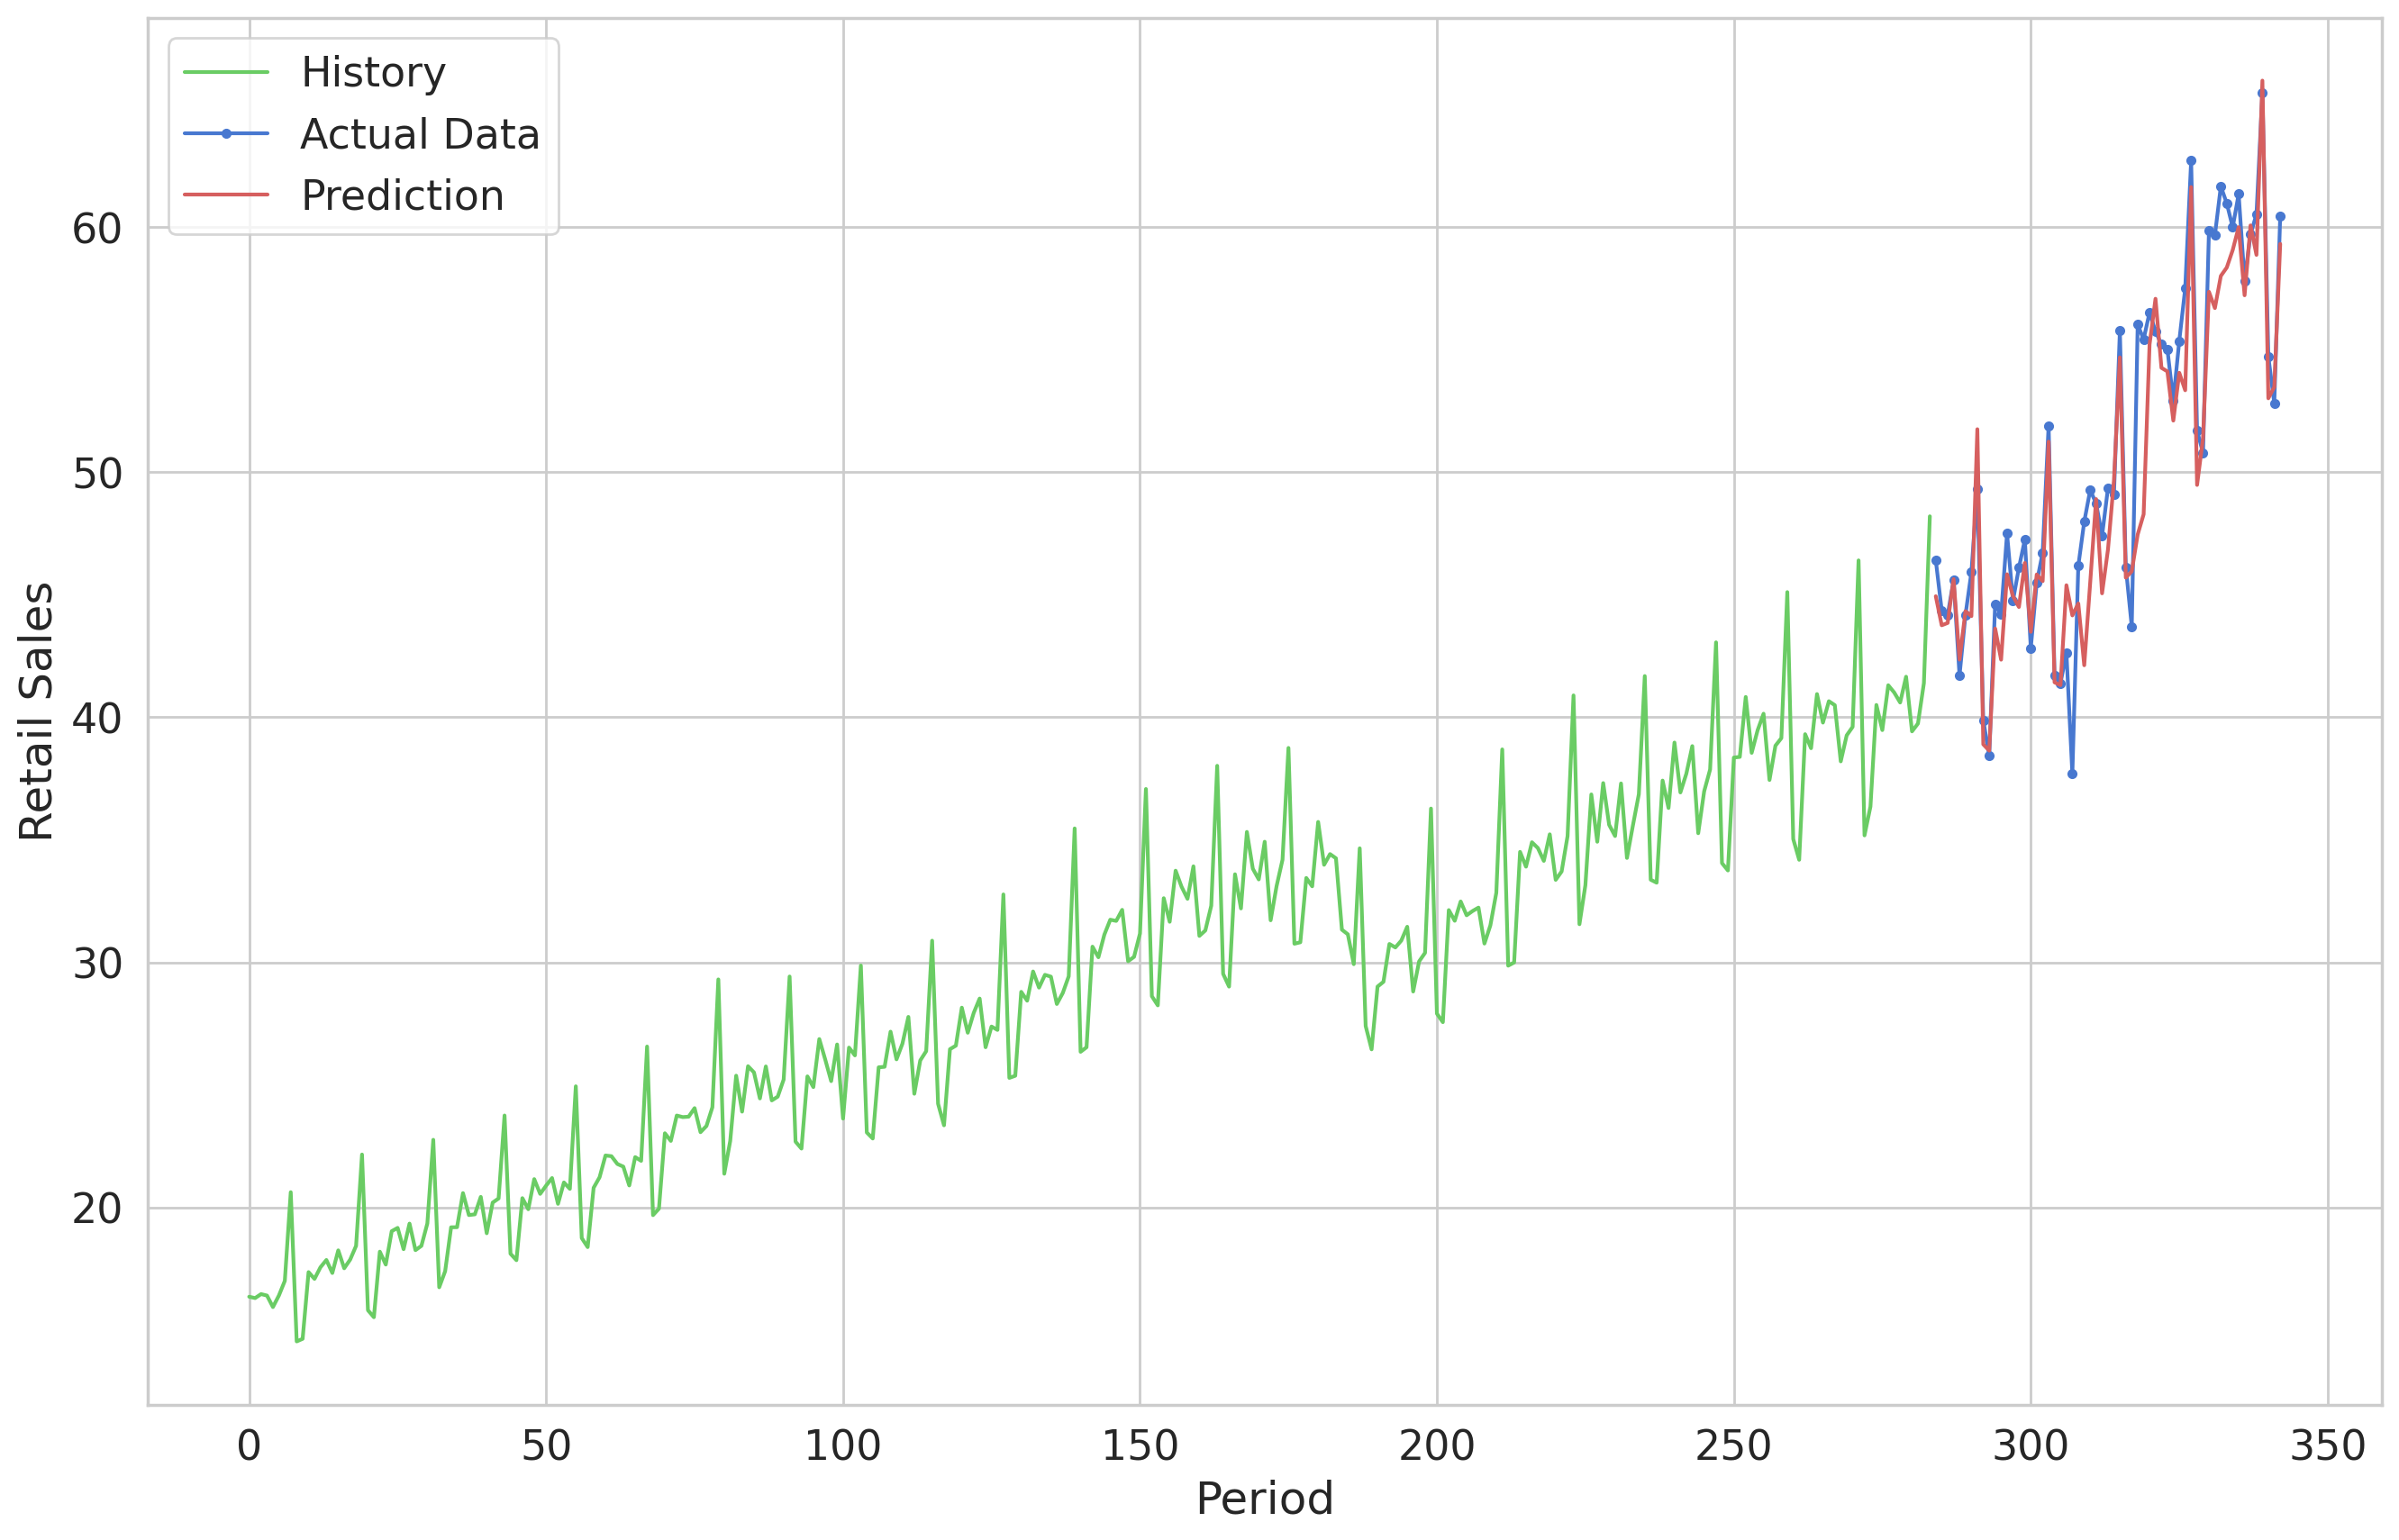

In [29]:
# Visualize predictions, actual test data, and the training data
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

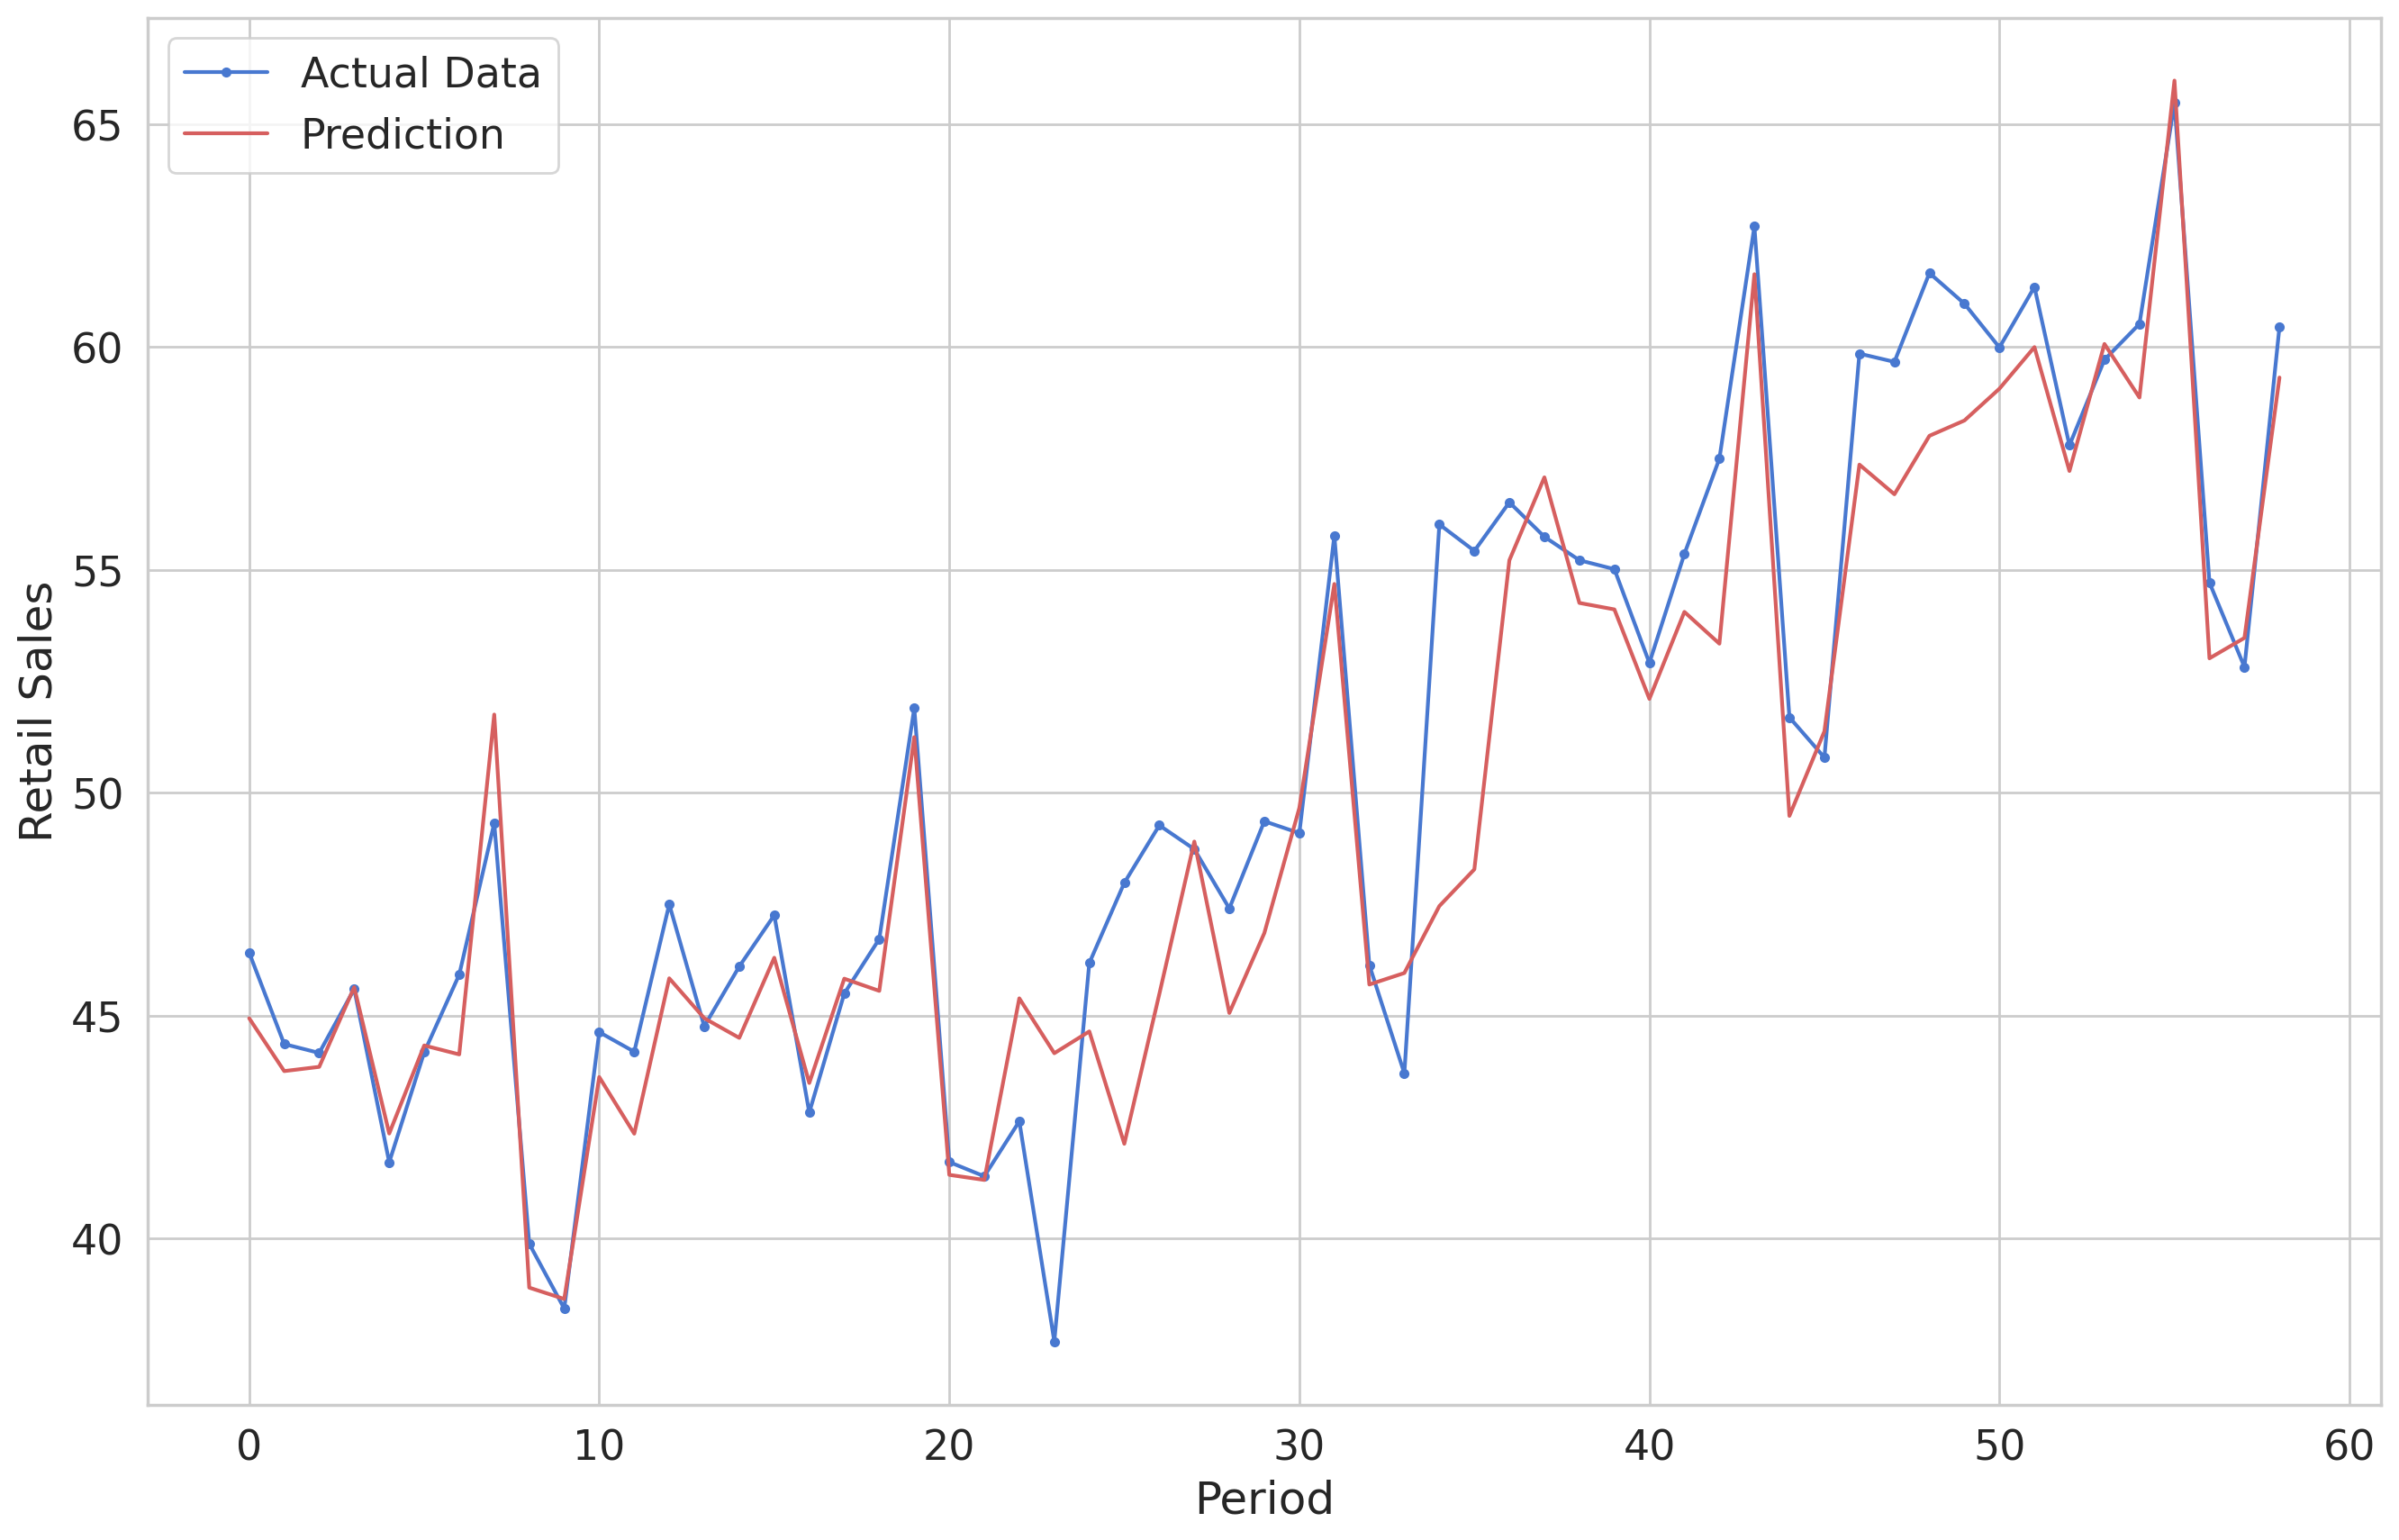

In [30]:
# Visualize predictions and the actual test data
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

## Comparison

As you can see above, the 1-D CNN model slightly outperforms the MLP model. The 1-D CNN model returns a mean-squared error of $5.8799$ on the validation set whereas the MLP model returns a mean-squared error of $7.9943$.